# Contacts vs distance tutorial
inspired by https://cooltools.readthedocs.io/en/latest/notebooks/contacts_vs_distance.html

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import core packages
import warnings
warnings.filterwarnings("ignore")
from itertools import combinations
import os

# import semi-core packages
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline
plt.style.use('seaborn-v0_8-poster')
import numpy as np
import pandas as pd
from multiprocessing import Pool

# import open2c libraries
import bioframe

import cooler
import cooltools
import cooltools.lib.plotting

from packaging import version
if version.parse(cooltools.__version__) < version.parse('0.5.2'):
    raise AssertionError("tutorial relies on cooltools version 0.5.2 or higher,"+
                         "please check your cooltools version and update to the latest")

# count cpus
num_cpus = os.getenv('SLURM_CPUS_PER_TASK')
if not num_cpus:
    num_cpus = os.cpu_count()
num_cpus = int(num_cpus)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
# Load a Hi-C map from a cooler file.
resolution = 50000 # kb
clr = cooler.Cooler(f'/Users/douglas/Documents/Features_Transfer/store_Hi-C/JJ10_11_17_18.wo3kbCisTransHom.{resolution}.cool')

In [4]:
view_df = pd.DataFrame({'chrom': clr.chromnames,
                        'start': 0,
                        'end': clr.chromsizes.values,
                        'name': clr.chromnames}
                      )
display(view_df)

,chrom,start,end,name
0,chr2L_057,0,23011544,chr2L_057
1,chr2R_057,0,21146708,chr2R_057
2,chr2L_439,0,23011544,chr2L_439
3,chr2R_439,0,21146708,chr2R_439
4,chr3L_057,0,24543557,chr3L_057
5,chr3R_057,0,27905053,chr3R_057
6,chr3L_439,0,24543557,chr3L_439
7,chr3R_439,0,27905053,chr3R_439
8,chrX_057,0,22422827,chrX_057


In [5]:
# obtain first 3 eigenvectors
cis_eigs = cooltools.eigs_cis(
                        clr,
                        view_df=view_df,
                        n_eigs=1,
                        )

# cis_eigs[0] returns eigenvalues, here we focus on eigenvectors
eigenvector_track = cis_eigs[1][['chrom','start','end','E1']]

In [6]:
# cvd == contacts-vs-distance
cvd = cooltools.expected_cis(
    clr=clr,
    view_df=view_df,
    smooth=False,
    aggregate_smoothed=False,
    nproc=num_cpus #if you do not have multiple cores available, set to 1
)

INFO:root:creating a Pool of 8 workers


In [ ]:
clr.matrix()
mat = clr.matrix(balance=True, sparse=True)[0:4317, 0:4317]
arr = mat.toarray()# fill in lower triangle

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
im = ax.matshow(np.log10(arr), cmap='fall',vmin = -5, vmax = -1)

fig.colorbar(im)
plt.show()

In [ ]:
display(cvd.head(4))
display(cvd.tail(4))

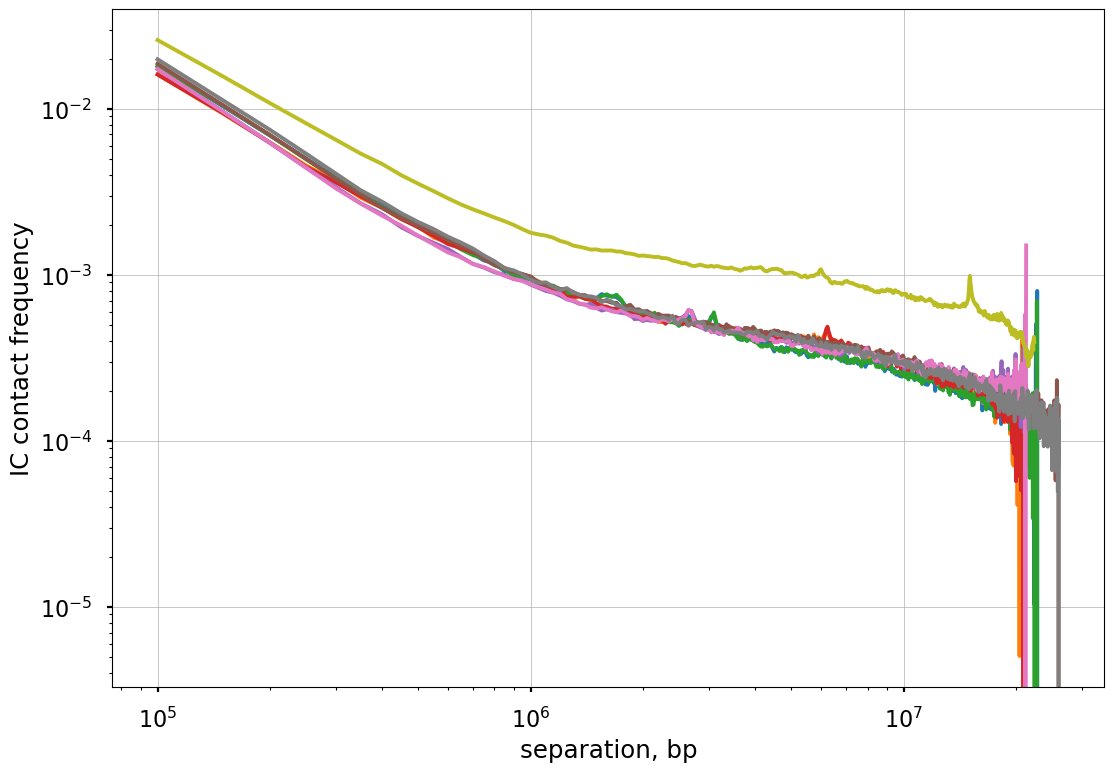

In [8]:
df = pd.DataFrame(view_df)  # Load your data here

f, ax = plt.subplots(1, 1)
for region in df['name']:
    ax.loglog(
        cvd['dist_bp'].loc[cvd['region1'] == region],
        cvd['contact_frequency'].loc[cvd['region1'] == region],
    )
    ax.set(
        xlabel='separation, bp',
        ylabel='IC contact frequency'
    )
    ax.grid(lw=0.5)


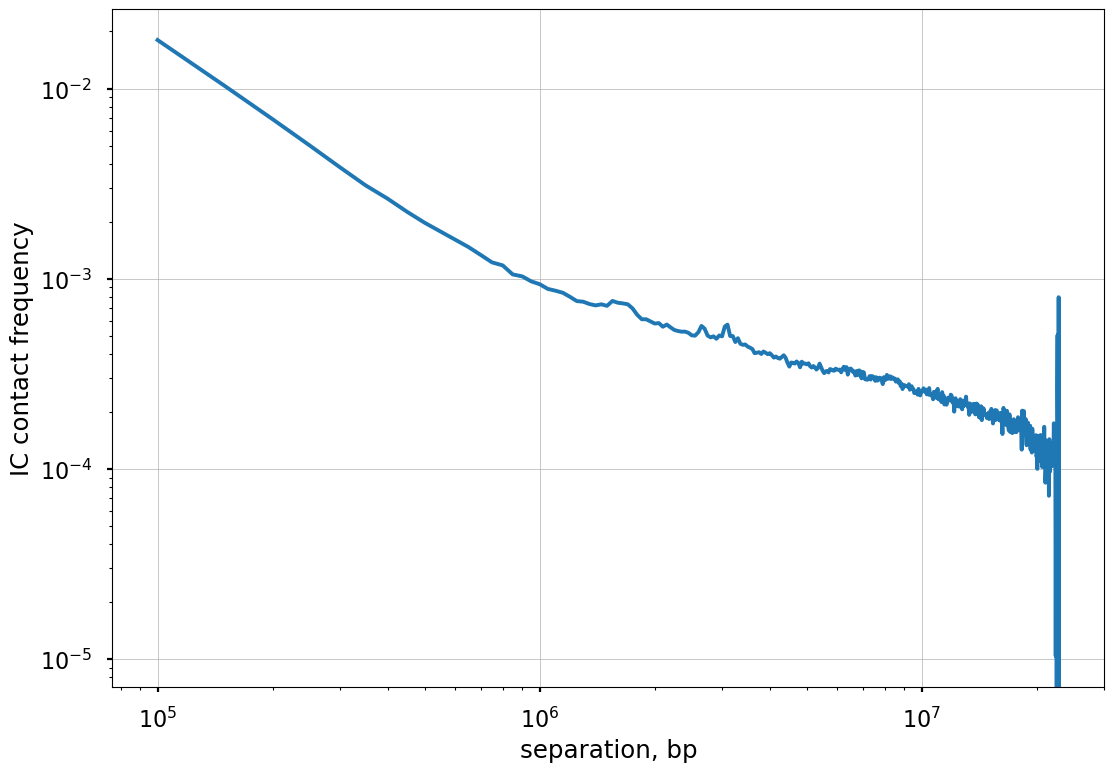

In [11]:
# Cell generated with copilot
region = 'chr2L_057'  # Replace 'region1' with your region of interest

f, ax = plt.subplots(1, 1)
ax.loglog(
    cvd['dist_bp'].loc[cvd['region1'] == region],
    cvd['contact_frequency'].loc[cvd['region1'] == region],
)
ax.set(
    xlabel='separation, bp',
    ylabel='IC contact frequency'
)
ax.grid(lw=0.5)


# Compartments tutorial
inspired by https://cooltools.readthedocs.io/en/latest/notebooks/compartments_and_saddles.html

In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os, subprocess

# Import python package for working with cooler files and tools for analysis
import cooler
import cooltools.lib.plotting

from packaging import version
if version.parse(cooltools.__version__) < version.parse('0.5.4'):
    raise AssertionError("tutorials rely on cooltools version 0.5.4 or higher,"+
                         "please check your cooltools version and update to the latest")

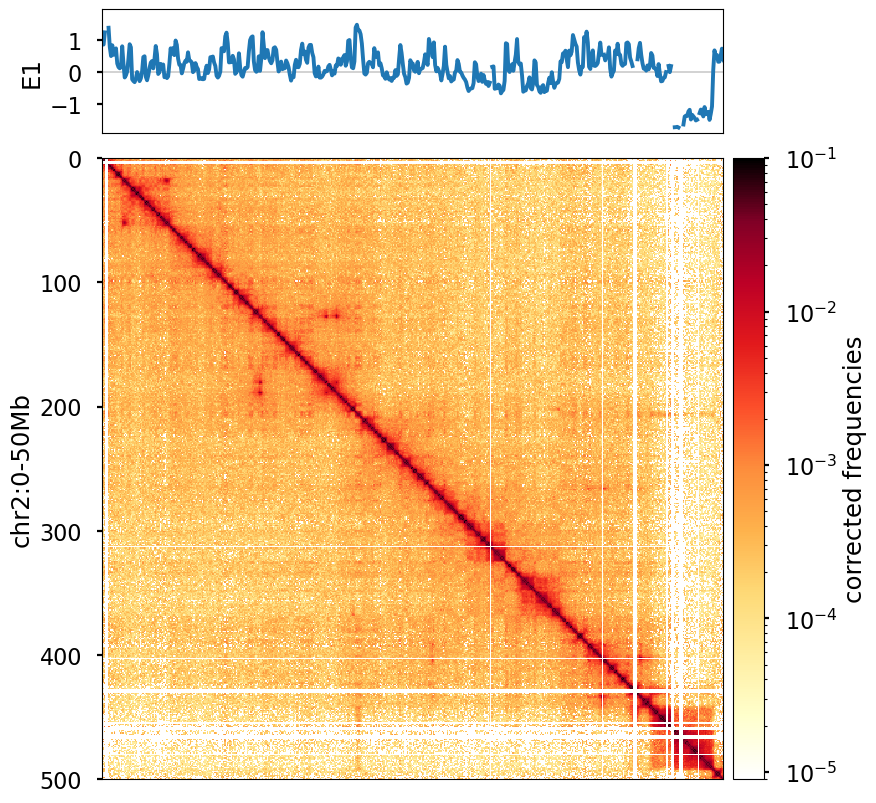

In [10]:
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

f, ax = plt.subplots(
    figsize=(15, 10),
)

norm = LogNorm(vmax=0.1)

im = ax.matshow(
    clr.matrix()[:],
    norm=norm,
    cmap='fall'
);
plt.axis([0,500,500,0])

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax, label='corrected frequencies');
ax.set_ylabel('chr2:0-50Mb')
ax.xaxis.set_visible(False)

ax1 = divider.append_axes("top", size="20%", pad=0.25, sharex=ax)
weights = clr.bins()[:]['weight'].values
ax1.plot([0,500],[0,0],'k',lw=0.25)
ax1.plot( eigenvector_track['E1'].values, label='E1')

ax1.set_ylabel('E1')
ax1.set_xticks([]);